In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

(4032, 3024)
0.0


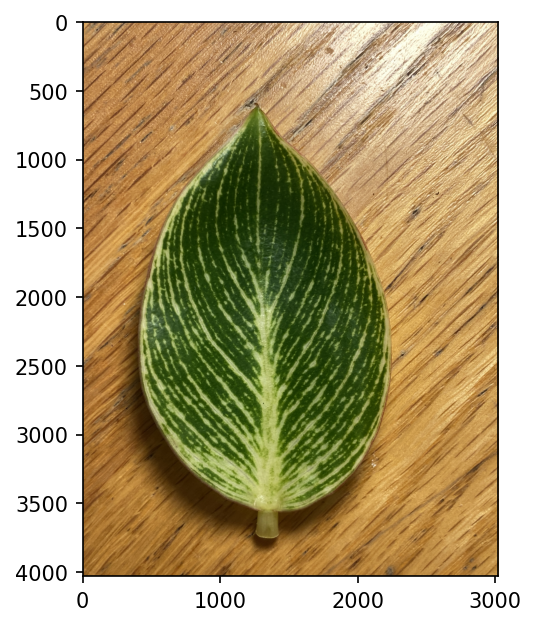

In [76]:
goat_jpg = Image.open('images/Goat.JPG')
leaf_jpg = Image.open('images/Leaf.JPG')
trees_jpg = Image.open('images/Trees.JPG')

goat = np.transpose(np.asarray(goat_jpg), axes=(1,0,2))
leaf = np.transpose(np.asarray(leaf_jpg), axes=(1,0,2))
trees = np.asarray(trees_jpg)

grayscale_goat = goat.mean(axis=2)
grayscale_leaf = leaf.mean(axis=2)
grayscale_trees = trees.mean(axis=2)

print(grayscale_goat.shape)
print(np.amin(grayscale_goat))
fig, axes = plt.subplots(dpi=150)
axes.imshow(leaf, cmap='gray')
plt.show()

In [5]:
def three_point_derivative(y):
    dy = np.empty(y.shape)
    
    dy[1:-1] = (y[2:] - y[:-2])/2
    dy[0] = (-3*y[0] + 4*y[1] - y[2])/2
    dy[-1] = (y[-3] - 4*y[-2] + 3*y[-1])/2

    return dy

def five_point_derivative(y):

    dy = np.empty(y.shape)

    dy[:2] = (-25*y[:2] + 48*y[1:3] - 36*y[2:4] + 16*y[3:5] - 3*y[4:6])/12
    dy[2:-2] = (y[:-4] - 8*y[1:-3] + 8*y[3:-1] - y[4:])/12
    dy[-2:] = (3*y[-6:-4] - 16*y[-5:-3] + 36*y[-4:-2] - 48*y[-3:-1] + 25*y[-2:])/12

    return dy

def seven_point_derivative(y):
    
    dy = np.empty(y.shape)

    dy[:3] = ((-49/20)*y[:3] + 6*y[1:4] - (15/2)*y[2:5] + (20/3)*y[3:6]
               - (15/4)*y[4:7] + (6/5)*y[5:8] - (1/6)*y[6:9])
    
    dy[3:-3] = (-y[:-6] + 9*y[1:-5] - 45*y[2:-4] + 45*y[4:-2] - 9*y[5:-1] + y[6:])/60
    
    dy[-3:] = ((49/20)*y[-3:] - 6*y[-4:-1] + (15/2)*y[-5:-2] - (20/3)*y[-6:-3]
                + (15/4)*y[-7:-4] - (6/5)*y[-8:-5] + (1/6)*y[-9:-6])
    
    return dy

def nine_point_derivative(y):

    dy = np.empty(y.shape)

    dy[:4] = ((-49/20)*y[:4] + 6*y[1:5] - (15/2)*y[2:6] + (20/3)*y[3:7]
               - (15/4)*y[4:8] + (6/5)*y[5:9] - (1/6)*y[6:10])

    dy[4:-4] = ((1/280)*y[:-8] - (4/105)*y[1:-7] + (1/5)*y[2:-6] - (4/5)*y[3:-5]
                 + (4/5)*y[5:-3] - (1/5)*y[6:-2] + (4/105)*y[7:-1] - (1/280)*y[8:])

    dy[-4:] = ((49/20)*y[-4:] - 6*y[-5:-1] + (15/2)*y[-6:-2] - (20/3)*y[-7:-3]
                + (15/4)*y[-8:-4] - (6/5)*y[-9:-5] + (1/6)*y[-10:-6])
    
    return dy

In [38]:
def blur_image(image, steps=1):
    
    if len(image.shape) == 2:
        result_shape = (image.shape[0] + 2*steps, image.shape[1] + 2*steps)
    elif len(image.shape) == 3:
        result_shape = (image.shape[0] + 2*steps, image.shape[1] + 2*steps, image.shape[2])

    image_sum = np.zeros(result_shape)
    layer_count = np.zeros((image.shape[0] + 2*steps, image.shape[1] + 2*steps))

    for h_offset in range(2*steps + 1):

        for v_offset in range(2*steps + 1):

            image_sum[h_offset:(h_offset + image.shape[0]), v_offset:(v_offset + image.shape[1])] += image
            layer_count[h_offset:(h_offset + image.shape[0]), v_offset:(v_offset + image.shape[1])] += 1
    blurred_image = (image_sum/layer_count)[steps:-steps, steps:-steps].astype(int)

    print(image.shape, blurred_image.shape)
    print(np.amin(blurred_image), np.amax(blurred_image))

    return (image_sum/layer_count)[steps:-steps, steps:-steps]

In [30]:
def convolve(image, kernel, stride=1):
    res_rows = int((image.shape[0]-1)/stride)
    res_cols = int((image.shape[1]-1)/stride)

    result = np.zeros((res_rows, res_cols, image.shape[2]))

    k_w = kernel.shape[0]
    w_pad = int((k_w - 1)/2)
    k_h = kernel.shape[1]
    h_pad = int((k_h - 1)/2)

    print(w_pad, h_pad)
    
    for r in tqdm(range(w_pad, image.shape[0] - w_pad, stride)):
        for c in range(h_pad, image.shape[1] - h_pad, stride):
            for chan in range(image.shape[2]):
                
                res_row = int((r - w_pad)/stride)
                res_col = int((c - h_pad)/stride)

                sub_image = image[(r - w_pad):(r + w_pad + 1), (c - h_pad):(c + h_pad + 1), chan]

                result[res_row][res_col][chan] = np.dot(sub_image.flatten(), kernel.flatten())
    
    return result

In [189]:
def show_image_hist(img, size=6):
    ''' Display a grayscale image with inset pixel brightness histogram'''

    if img.shape[0] > img.shape[1]:
        figsize = (img.shape[1]/img.shape[0]*size, size)
    else:
        figsize = (size, img.shape[0]/img.shape[1]*size)

    fig, ax = plt.subplots(figsize=figsize, dpi=150)
    ax.imshow(img, cmap='gray')
    ax.set_axis_off()
    x0, y0, x1, y1 = ax.get_position().bounds
    sub_ax = fig.add_axes((x0, y0, 0.1, 0.1))
    sub_ax.hist(img.flatten(), 100, log=True)
    sub_ax.set_axis_off()
    plt.show()

In [70]:
def normalize(data):
    return (data - np.amin(data))/(np.amax(data) - np.amin(data))

In [50]:
kernel = np.ones((21, 21))/441
convolve_blur_goat = convolve(goat, kernel, stride=4)
print(convolve_blur_goat.shape)

10 10


100%|██████████| 1003/1003 [00:05<00:00, 167.89it/s]

(1007, 755, 3)


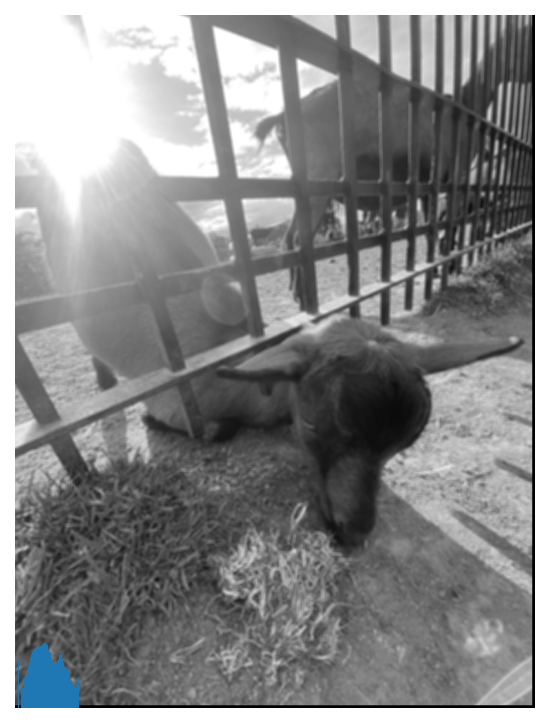

In [197]:
gray_convolve_goat = np.mean(convolve_blur_goat, axis=2)
show_image_hist(gray_convolve_goat)

(4032, 3024) (4032, 3024)
10 255


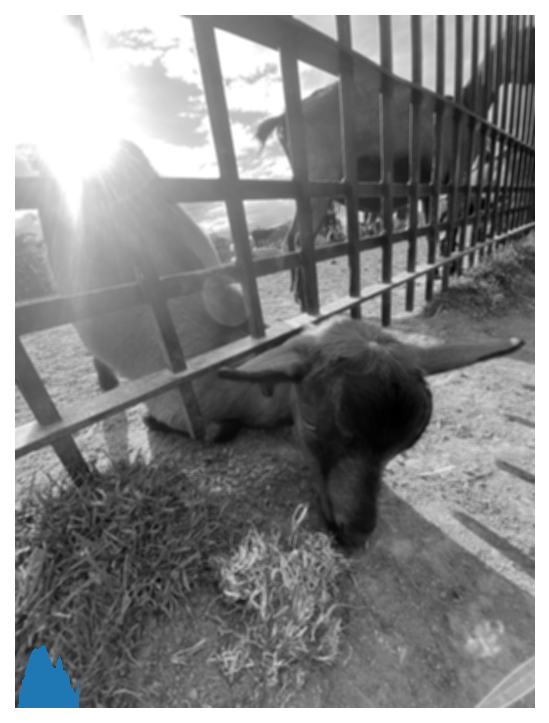

In [198]:
blurry_goat = blur_image(grayscale_goat, steps=10)
show_image_hist(blurry_goat)

In [54]:
def detect_edges(image, derivative_function, threshold=0.5):
    ''' Detect edges in a grayscale image'''
    rows = image.shape[0]
    cols = image.shape[1]

    row_grad = np.empty(image.shape)
    col_grad = np.empty(image.shape)

    for row in range(rows):
        row_grad[row] = derivative_function(image[row])
    
    for col in range(cols):
        col_grad[:,col] = derivative_function(image[:,col])

    grad_mag = (row_grad**2 + col_grad**2)**0.5

    grad_norm = (grad_mag - np.amin(grad_mag))/(np.amax(grad_mag) - np.amin(grad_mag))

    return grad_norm

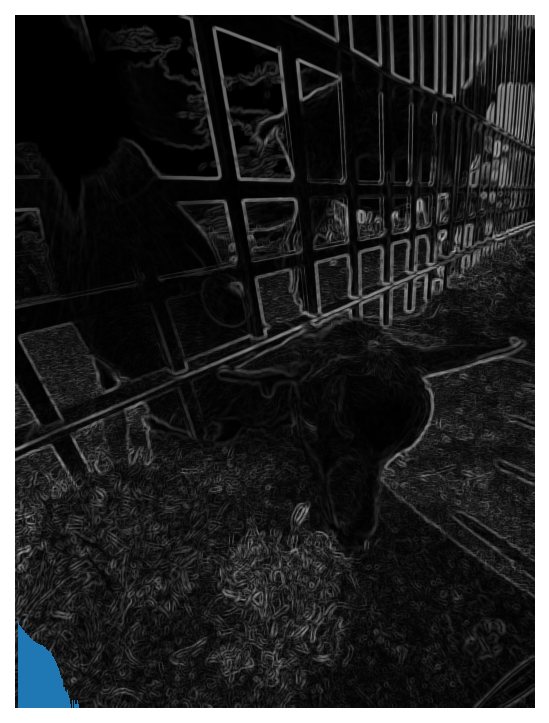

In [205]:
goat_edges = detect_edges(blurry_goat, nine_point_derivative)
show_image_hist(goat_edges)

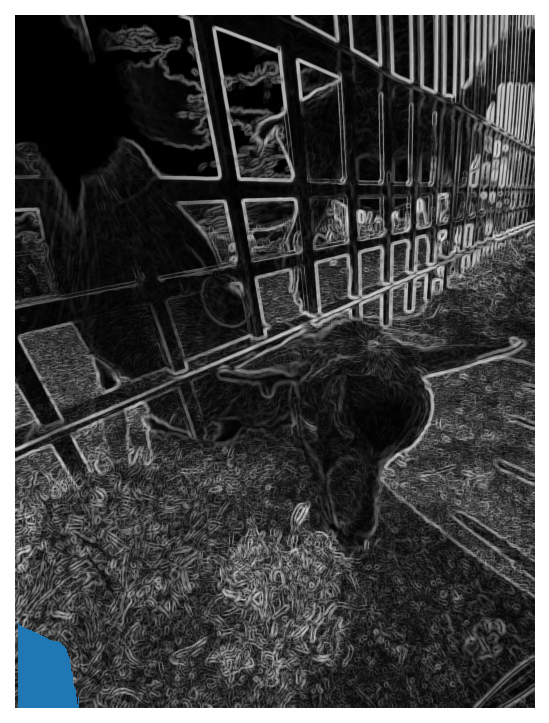

In [207]:
inv_goat_edges = normalize(-1/(goat_edges + 0.5))
show_image_hist(inv_goat_edges)

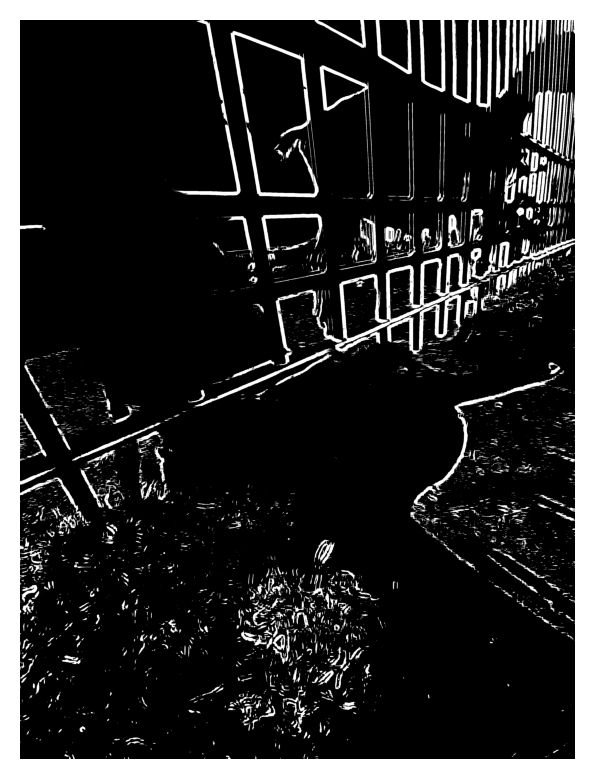

In [208]:
filtered_goat_edges = inv_goat_edges > 0.5

fig, axes = plt.subplots(dpi=200)
axes.imshow(filtered_goat_edges, cmap='gray')
axes.set_axis_off()
plt.show()

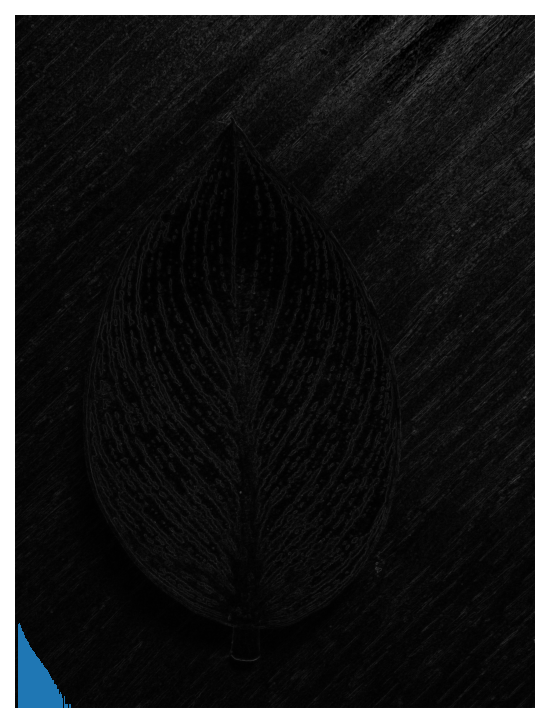

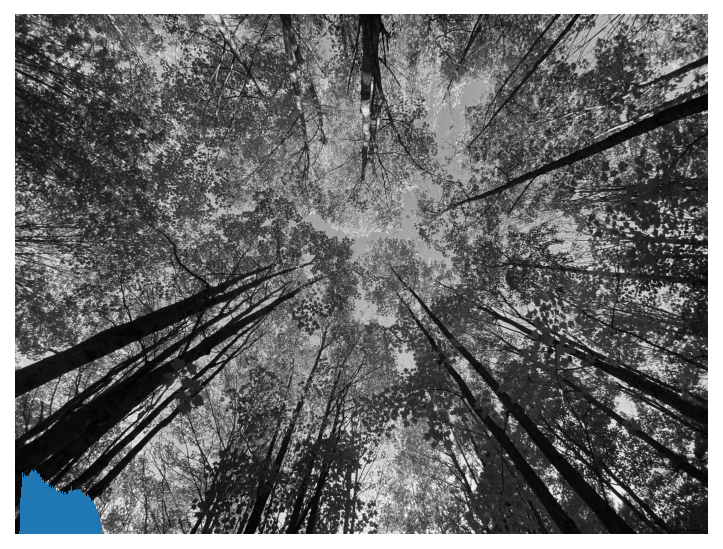

In [190]:
leaf_edges = detect_edges(grayscale_leaf, nine_point_derivative)

show_image_hist(leaf_edges)
show_image_hist(grayscale_trees)

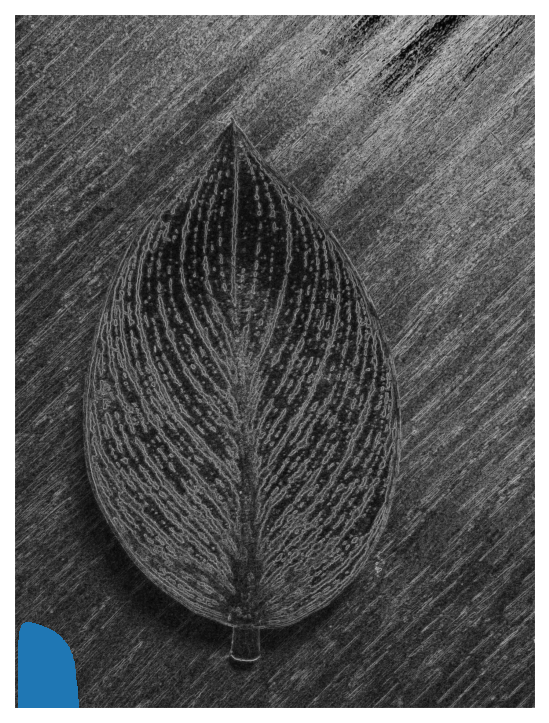

In [191]:
inverted_leaf = normalize(-1/(leaf_edges + 0.1))

show_image_hist(inverted_leaf)

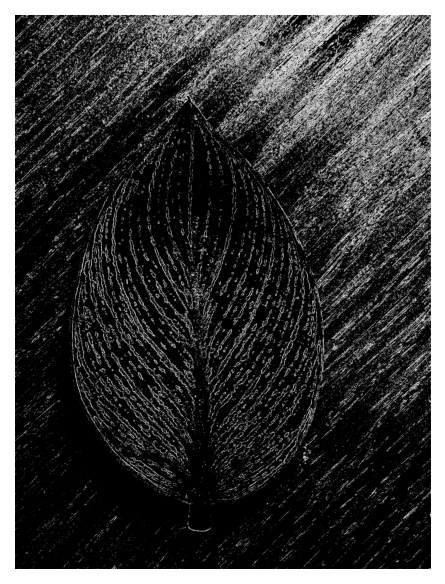

In [195]:
filtered_leaf = inverted_leaf > 0.5
fig, axes = plt.subplots(dpi=150)
axes.imshow(filtered_leaf, cmap='gray')
axes.set_axis_off()
plt.show()

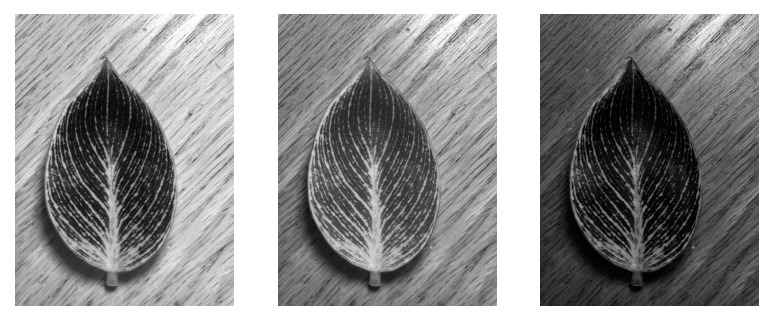

In [82]:

fig, axes = plt.subplots(1,3, dpi=150)
axes[0].imshow(leaf[:,:,0], cmap='gray')
axes[0].axis('off')
axes[1].imshow(leaf[:,:,1], cmap='gray')
axes[1].axis('off')
axes[2].imshow(leaf[:,:,2], cmap='gray')
axes[2].axis('off')

plt.show()